# Pruning ResNet-20 for CIFAR10 dataset
reference : https://git.ecdf.ed.ac.uk/s1886313/tensorflow/-/tree/aabe9698daf5004ec90f04e2da5b71b51b010b6d/tensorflow/contrib/model_pruning

In [ ]:
!pip install numpy
!pip install tensorflow-model-optimization
!pip install matplotlib
!pip install tf-keras

In [ ]:
import shutil
from pathlib import Path

import numpy as np
from tensorflow import keras
import tensorflow as tf
import tf_keras as keras
from tf_keras import layers, models, regularizers, datasets, utils, callbacks, optimizers, losses
from tf_keras.preprocessing.image import ImageDataGenerator
from tf_keras.datasets import cifar10

In [ ]:
BATCH_SIZE = 128

TRAIN_LOGS_FOLDER_PATH = Path("./train_logs")
if TRAIN_LOGS_FOLDER_PATH.is_dir():
    shutil.rmtree(str(TRAIN_LOGS_FOLDER_PATH))
TRAIN_LOGS_FOLDER_PATH.mkdir(exist_ok=True)

# Loading data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Data Transform
x_train = x_train.astype(np.float32) / 255.0
y_train = utils.to_categorical(y_train)
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean

x_test = x_test.astype(np.float32) / 255.0
y_test = utils.to_categorical(y_test)
x_test -= x_train_mean

print("Train shape: X {0}, y: {1}".format(x_train.shape, y_train.shape))
print("Test shape: X {0}, y: {1}".format(x_test.shape, y_test.shape))
STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE

170498071/170498071 [==============================] - 8s 0us/step
Train shape: X (50000, 32, 32, 3), y: (50000, 10)
Test shape: X (10000, 32, 32, 3), y: (10000, 10)


## Build ResNet-20
`prune_low_magnitude` only accepts inputs of type `keras.layers` or `keras.Sequential`.
The ResNet-20 class is of type `keras.Model`.
Therefore, we need to re-implement ResNet-20 using `keras.Sequential`.

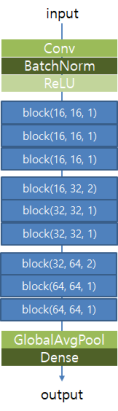

In [ ]:
from tensorflow.keras import layers

# build model using Residual block without class
def resnet_block(f1, f2, s, input):
  kernel_initializer = 'he_normal'
  strides = s

  shortcut = input
  output = layers.Conv2D(filters=f1, kernel_size=3, strides=s, padding='same', kernel_initializer=kernel_initializer)(input)
  output = layers.BatchNormalization()(output)
  output = layers.ReLU()(output)
  output = layers.Conv2D(filters=f2, kernel_size=3, strides=1, padding='same', kernel_initializer=kernel_initializer)(output)

  if strides == 2:
    shortcut = keras.Sequential([
        layers.Conv2D(filters=f2, kernel_size=1, strides=s, kernel_initializer=kernel_initializer, padding='same'),
        layers.BatchNormalization()
    ])(input)
  else:
    shortcut = layers.BatchNormalization()(shortcut)

  output = layers.add([output, shortcut])
  output = layers.ReLU()(output)
  return output

# ResNet
input_shape = (32,32,3)
image_input = layers.Input(shape=input_shape)

## First layer
output = keras.Sequential([
    layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.ReLU()
])(image_input)

## ResNet blocks
# implement blocks here
# use resnet_block()
# using for() can make code short

# Last layers
predictions = keras.Sequential([
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dense(10, kernel_initializer='he_normal')
])(output)

# Create the Sequential model with the flattened list of layers
model = keras.Model(inputs=image_input, outputs=predictions)
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

TypeError: The added layer must be an instance of class Layer. Received: layer=<Conv2D name=conv2d_1, built=False> of type <class 'keras.src.layers.convolutional.conv2d.Conv2D'>.

In [ ]:
# Train model
model.fit(x_train,
          y_train,
          epochs=4,
          validation_split=0.1)

model.summary()

In [ ]:
_, baseline_model_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"baseline_model_accuracy:{baseline_model_accuracy}")

## Pruning

Using the methods learned from the examples on how to use the Keras pruning module, we will prune ResNet-20.

In [ ]:
import tensorflow_model_optimization as tfmot
prune_log_magnitude = tfmot.sparsity.keras.prune_low_magnitude

pruning_params_2_by_4 = {
    'sparsity_m_by_n': (2, 4),
}

pruning_params_sparsity_0_5 = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(target_sparsity=0.5,
                                                              begin_step=0,
                                                              frequency=100)
}


In [ ]:
from tensorflow_model_optimization.python.core.sparsity.keras.prune import prune_low_magnitude
model_to_prune = model
# implement prune_low_magnitude here
model_to_prune = prune_low_magnitude(model_to_prune, **pruning_params_sparsity_0_5)
model_to_prune.compile(optimizer='adam',
                       loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'])

In [ ]:
# Train model
model_to_prune.fit(x_train,
          y_train,
          epochs=4,
          validation_split=0.1,
          callbacks=[tfmot.sparsity.keras.UpdatePruningStep()])

model_to_prune.summary()

In [ ]:
_, pruned_model_accuracy = model_to_prune.evaluate(x_test, y_test, verbose=0)
print('Baseline test accuracy:', baseline_model_accuracy)
print('Pruned test accuracy:', pruned_model_accuracy)